# Predicting Financial Time Series Data with Machine Learning

This is a sample that predicts future prices from past price movements.
Here we implement it with EUR/USD rate as an example, but you can convert it to stock price by editing the symbol.


In [ ]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
%matplotlib inline

# Time period
d1 = datetime.datetime(2013, 1, 1)
d2 = datetime.datetime(2023, 10, 17)

# Fetching data from Yahoo Finance using yfinance
df = yf.download('EURUSD=X', start=d1, end=d2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-01,1.320132,1.322401,1.319592,1.320132,1.320132,0
2013-01-02,1.319784,1.329805,1.319435,1.319784,1.319784,0
2013-01-03,1.318392,1.318913,1.308900,1.318218,1.318218,0
2013-01-04,1.303101,1.306380,1.300052,1.303271,1.303271,0
2013-01-07,1.306848,1.309929,1.302060,1.306745,1.306745,0


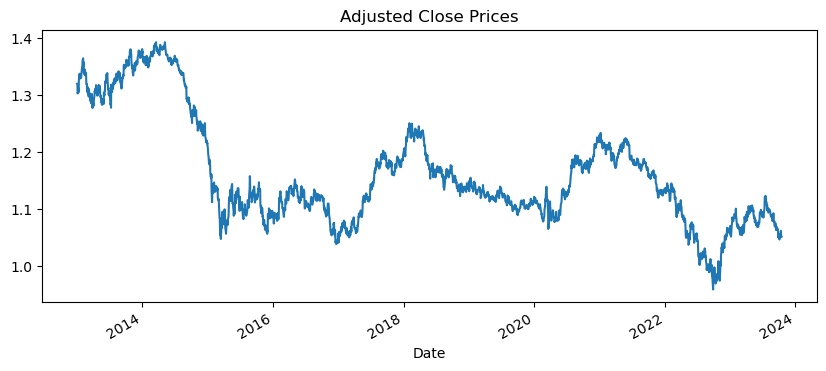

In [4]:
# Invert values of the 'Open', 'High', 'Low', 'Close', and 'Adj Close' columns
df[['Open', 'High', 'Low', 'Close', 'Adj Close']] = df[['Open', 'High', 'Low', 'Close', 'Adj Close']].applymap(lambda x: 1.0/x)

# Display the head of the DataFrame
display(df.head())

# Plot the adjusted close prices
df['Adj Close'].plot(figsize=(10,4))
plt.title('Adjusted Close Prices')
plt.show()

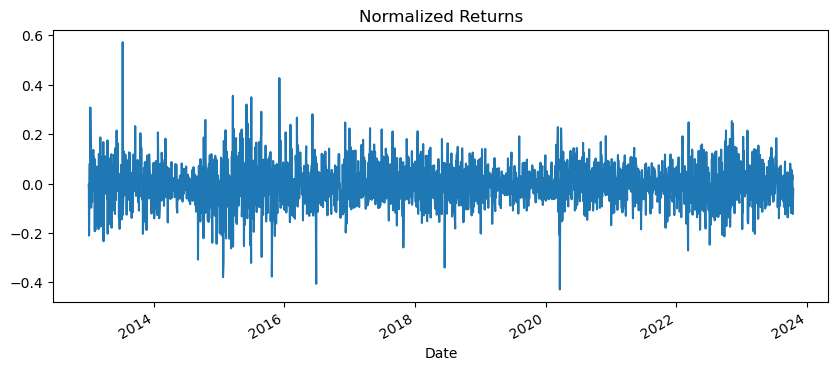

In [5]:
# Calculate the daily returns
df['return'] = df['Adj Close'] - df['Adj Close'].shift(1)

# Normalize the return values
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

# Plot the normalized return values
df['return'].plot(figsize=(10,4))
plt.title('Normalized Returns')
plt.show()

In [6]:
# Create a label column: 1 indicates a rising price, and 0 indicates a falling price or no change
df['label'] = df['return'].shift(-1).apply(lambda x: 1 if x > 0.0 else 0)

# Display the last few rows of the DataFrame to verify the new 'label' column
df.tail()

,Open,High,Low,Close,Adj Close,Volume,return,label
Date,,,,,,,,
2023-10-10,1.057888,1.061954,1.055598,1.057888,1.057888,0,0.016057,1
2023-10-11,1.060479,1.063355,1.059277,1.060479,1.060479,0,0.036496,1
2023-10-12,1.062428,1.063909,1.054596,1.062428,1.062428,0,0.027448,0
2023-10-13,1.053674,1.055855,1.049615,1.053674,1.053674,0,-0.123280,0
2023-10-16,1.052155,1.055465,1.051635,1.052155,1.052155,0,-0.021387,0


In [8]:
# Number of features for training
n_features = 60

# Create sliding windows for train_x and corresponding labels for train_y
train_x = np.array([df['return'].values[i-n_features:i] for i in range(n_features, len(df))])
train_y = df['label'].values[n_features:]

# Display the shapes of train_x and train_y
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)

# Display the percentage distribution of the two classes in train_y
print('%% of Class0 : {:.2f}%'.format(100 * np.count_nonzero(train_y == 0) / float(len(train_y))))
print('%% of Class1 : {:.2f}%'.format(100 * np.count_nonzero(train_y == 1) / float(len(train_y))))

train_x shape: (2751, 60)
train_y shape: (2751,)
%% of Class0 : 50.45%
%% of Class1 : 49.55%


In [9]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing
from sklearn.ensemble import GradientBoostingClassifier

# Remove rows with NaN values from train_x and train_y
nan_indices = np.where(np.isnan(train_x).sum(axis=1))[0]
train_x = np.delete(train_x, nan_indices, axis=0)
train_y = np.delete(train_y, nan_indices, axis=0)

# Define the Gradient Boosting Classifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000)

# Define the split point for training and testing data
split_point = int(len(train_x) * 0.95)

# Split the data
X_train, X_test = train_x[:split_point], train_x[split_point:]
y_train, y_test = train_y[:split_point], train_y[split_point:]

# Train the classifier
clf.fit(X_train, y_train)

# Evaluate the classifier's accuracy on the test data
accuracy = clf.score(X_test, y_test)
print('Testing Accuracy: {:.2f}%'.format(accuracy * 100))

Testing Accuracy: 58.70%


,return,actual,predicted,won,pnl,equity
133,0.029350,1,1,True,293.497494,4762.724156
134,0.016057,1,1,True,160.573330,4923.297486
135,0.036496,0,1,False,-364.962278,4558.335208
136,0.027448,0,0,True,274.477150,4832.812358
137,-0.123280,0,0,True,1232.796914,6065.609272


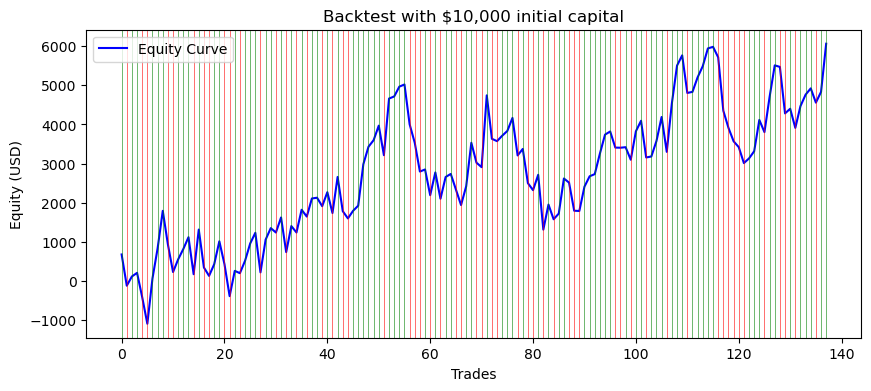

In [10]:
# Predict the test data
predictions = clf.predict(X_test)

# Define trading parameters
contracts = 10000.0
commission = 0.0

# Create a DataFrame to hold trade data
df_trade = pd.DataFrame({
    'return': X_test[:, -1],  # Last column of X_test contains the returns
    'actual': y_test,
    'predicted': predictions
})

# Determine if the prediction was correct
df_trade['won'] = df_trade['actual'] == df_trade['predicted']

# Calculate profit or loss for each trade
df_trade['pnl'] = df_trade.apply(
    lambda row: (abs(row['return']) * contracts - commission) if row['won'] else (-abs(row['return']) * contracts - commission),
    axis=1
)

# Calculate cumulative equity
df_trade['equity'] = df_trade['pnl'].cumsum()

# Display the last few rows of the trading DataFrame
display(df_trade.tail())

# Plot the equity curve
plt.figure(figsize=(10,4))
plt.plot(df_trade['equity'], label='Equity Curve', color='blue')
plt.title('Backtest with $10,000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for idx, row in df_trade.iterrows():
    color = 'g' if row['won'] else 'r'
    plt.axvline(x=idx, linewidth=0.5, alpha=0.8, color=color)
plt.legend()
plt.show()

Net Profit            : $6065.61
Number Winning Trades : 81
Number Losing Trades  : 57
Percent Profitable    : 58.70%
Avg Win Trade         : $468.168
Avg Loss Trade        : $-558.877
Largest Win Trade     : $1837.486
Largest Loss Trade    : $-1402.788
Profit Factor         : 1.19


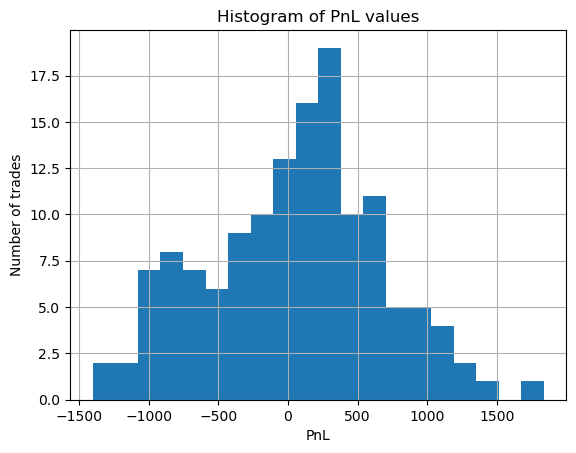

In [11]:
# Calculate trade summaries

# Count the number of winning and losing trades
winning_trades = df_trade[df_trade['pnl'] > 0.0]
losing_trades = df_trade[df_trade['pnl'] < 0.0]

# Display trade summaries
print("Net Profit            : ${:.2f}".format(df_trade['equity'].iloc[-1]))
print("Number Winning Trades : {}".format(len(winning_trades)))
print("Number Losing Trades  : {}".format(len(losing_trades)))
print("Percent Profitable    : {:.2f}%".format(100 * len(winning_trades) / len(df_trade)))
print("Avg Win Trade         : ${:.3f}".format(winning_trades['pnl'].mean()))
print("Avg Loss Trade        : ${:.3f}".format(losing_trades['pnl'].mean()))
print("Largest Win Trade     : ${:.3f}".format(winning_trades['pnl'].max()))
print("Largest Loss Trade    : ${:.3f}".format(losing_trades['pnl'].min()))

# Calculate and display the profit factor
if losing_trades['pnl'].sum() != 0:
    profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum())
    print("Profit Factor         : {:.2f}".format(profit_factor))
else:
    print("Profit Factor         : Infinite (No losing trades)")

# Plot the histogram of the PnL values
df_trade['pnl'].hist(bins=20)
plt.title("Histogram of PnL values")
plt.xlabel("PnL")
plt.ylabel("Number of trades")
plt.show()